In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder

## (0) Loading the Dataset

In [117]:
url = "https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_Houses_dataset.csv"
data = pd.read_csv(url)

# Selecting some columns of interest
selected_features = ['GrLivArea',
                     'BedroomAbvGr',
                     'KitchenAbvGr',
                     'OverallCond',
                     'RoofSurface',
                     'GarageFinish',
                     'CentralAir',
                     'ChimneyStyle',
                     'MoSold',
                     'SalePrice']

data = data[selected_features].copy()

data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,GarageFinish,CentralAir,ChimneyStyle,MoSold,SalePrice
0,1710,3,1,5,1995.0,RFn,Y,bricks,2,208500
1,1262,3,1,8,874.0,RFn,Y,bricks,5,181500
2,1786,3,1,5,1593.0,RFn,Y,castiron,9,223500
3,1717,3,1,5,2566.0,Unf,Y,castiron,2,140000
4,2198,4,1,5,3130.0,RFn,Y,bricks,12,250000


## (1) Duplicates

In [118]:
# ❓ How many duplicated rows are there in the dataset ❓
print(data.duplicated().sum())

300


In [119]:
#❓ Remove the duplicates from the dataset. Overwite the dataframe `data`❓
data = data.drop_duplicates()
print(data.duplicated().sum())

0


## (2) Missing Data

In [120]:
# ❓ Print the percentage of missing values for every column of the dataframe. ❓
data.isnull().sum().sort_values(ascending=False) / len(data)

GarageFinish    0.055479
RoofSurface     0.006164
BedroomAbvGr    0.000000
GrLivArea       0.000000
OverallCond     0.000000
KitchenAbvGr    0.000000
CentralAir      0.000000
ChimneyStyle    0.000000
MoSold          0.000000
SalePrice       0.000000
dtype: float64

In [121]:
# Investigate the missing values in `GarageFinish`
# Dados faltantes podem indicar provavelmente que não existe garagem -> NaN -> NoGarage
data.GarageFinish = data.GarageFinish.replace(np.nan, 'NoGarage')

In [122]:
data.isnull().sum().sort_values(ascending=False) / len(data)

RoofSurface     0.006164
GrLivArea       0.000000
BedroomAbvGr    0.000000
KitchenAbvGr    0.000000
OverallCond     0.000000
GarageFinish    0.000000
CentralAir      0.000000
ChimneyStyle    0.000000
MoSold          0.000000
SalePrice       0.000000
dtype: float64

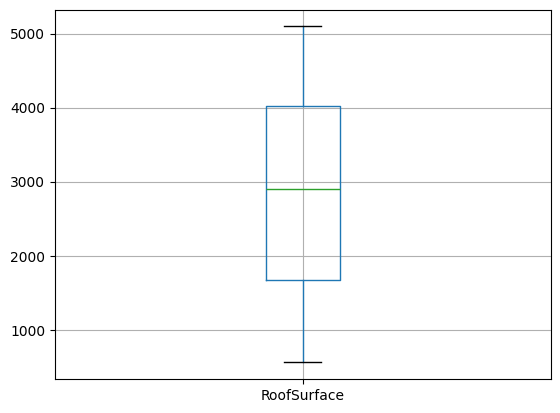

In [123]:
# Investigate the missing values in `RoofSurface`
# Valores numericos, poucos valores faltantes -> verificar outliers
data[['RoofSurface']].boxplot()
plt.show()

In [124]:
# Sem outliers -> inputar pela media
imputer = SimpleImputer(strategy="mean")

imputer.fit(data[["RoofSurface"]])
data['RoofSurface'] = imputer.transform(data[["RoofSurface"]])

imputer.statistics_

array([2863.20330806])

In [125]:
data.isnull().sum().sort_values(ascending=False) / len(data)

GrLivArea       0.0
BedroomAbvGr    0.0
KitchenAbvGr    0.0
OverallCond     0.0
RoofSurface     0.0
GarageFinish    0.0
CentralAir      0.0
ChimneyStyle    0.0
MoSold          0.0
SalePrice       0.0
dtype: float64

In [126]:
# Investigate the missing values in `ChimneyStyle`
data["ChimneyStyle"].unique()

array(['bricks', 'castiron', '?'], dtype=object)

In [127]:
data["ChimneyStyle"] = data["ChimneyStyle"].replace('?', np.nan)

In [128]:
data.isnull().sum().sort_values(ascending=False) / len(data)

ChimneyStyle    0.996575
GrLivArea       0.000000
BedroomAbvGr    0.000000
KitchenAbvGr    0.000000
RoofSurface     0.000000
OverallCond     0.000000
GarageFinish    0.000000
CentralAir      0.000000
MoSold          0.000000
SalePrice       0.000000
dtype: float64

In [129]:
# A quantidade de valores faltantes é muito grande -> dropar
data = data.drop(columns=["ChimneyStyle"])
data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,GarageFinish,CentralAir,MoSold,SalePrice
0,1710,3,1,5,1995.0,RFn,Y,2,208500
1,1262,3,1,8,874.0,RFn,Y,5,181500
2,1786,3,1,5,1593.0,RFn,Y,9,223500
3,1717,3,1,5,2566.0,Unf,Y,2,140000
4,2198,4,1,5,3130.0,RFn,Y,12,250000


## (3) Scaling

In [130]:
data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,GarageFinish,CentralAir,MoSold,SalePrice
0,1710,3,1,5,1995.0,RFn,Y,2,208500
1,1262,3,1,8,874.0,RFn,Y,5,181500
2,1786,3,1,5,1593.0,RFn,Y,9,223500
3,1717,3,1,5,2566.0,Unf,Y,2,140000
4,2198,4,1,5,3130.0,RFn,Y,12,250000


In [131]:
#❓ Cross-validate a linear regression model that predicts `SalePrice` using the other features ❓
X = data.select_dtypes(exclude="object").drop("SalePrice", axis=1)
y = data['SalePrice']

LR = LinearRegression()

scores = cross_val_score(LR, X, y, cv=10)
scores.mean()

np.float64(0.5776415365864919)

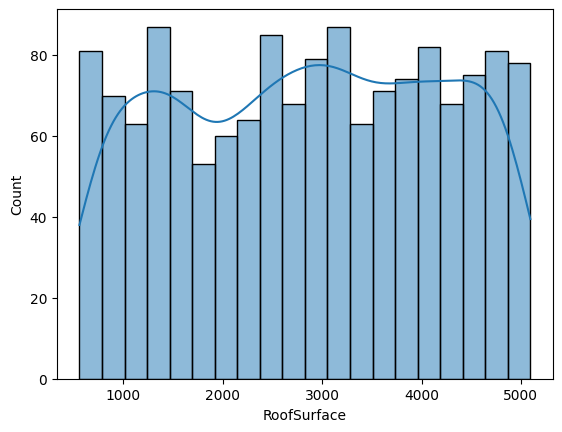

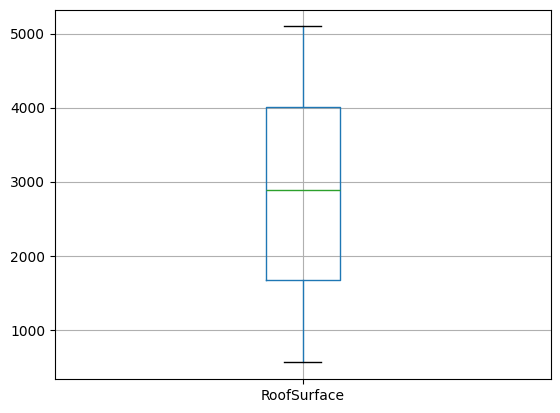

In [132]:
#❓ **Question** about `RoofSurface` ❓
sns.histplot(data['RoofSurface'], bins=20, kde=True)
plt.show()

data[['RoofSurface']].boxplot()
plt.show()

In [133]:
# Distribuição não é normal e não há outliers -> MinMaxScaler
minmax_scaler = MinMaxScaler()
data[["RoofSurface"]] = minmax_scaler.fit_transform(data[["RoofSurface"]])
data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,GarageFinish,CentralAir,MoSold,SalePrice
0,1710,3,1,5,0.316729,RFn,Y,2,208500
1,1262,3,1,8,0.069650,RFn,Y,5,181500
2,1786,3,1,5,0.228124,RFn,Y,9,223500
3,1717,3,1,5,0.442583,Unf,Y,2,140000
4,2198,4,1,5,0.566894,RFn,Y,12,250000


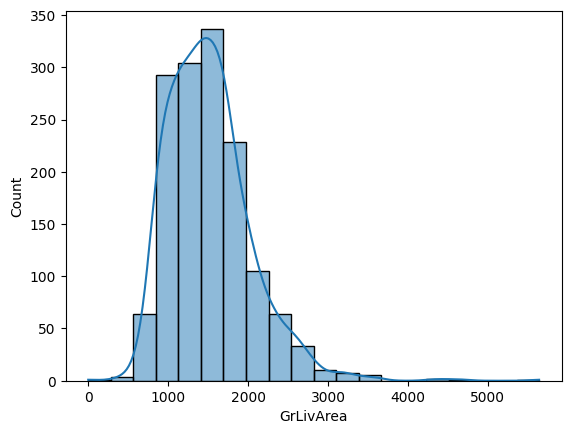

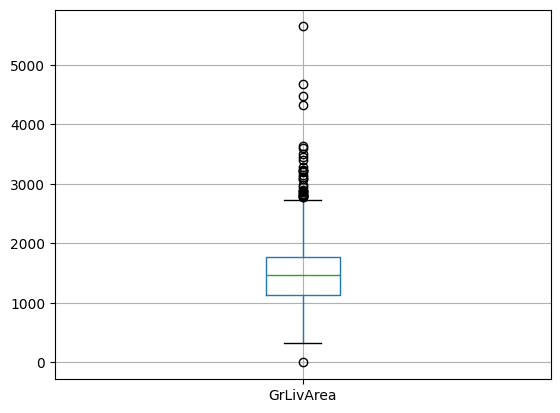

In [134]:
# 👇 Investigate `GrLivArea` for distribution and outliers
sns.histplot(data['GrLivArea'], bins=20, kde=True)
plt.show()

data[['GrLivArea']].boxplot()
plt.show()

In [135]:
# Quantidade absurda de outliers -> RobustScaler
robust_scaler = RobustScaler()
data[["GrLivArea"]] = robust_scaler.fit_transform(data[['GrLivArea']])
data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,GarageFinish,CentralAir,MoSold,SalePrice
0,0.380070,3,1,5,0.316729,RFn,Y,2,208500
1,-0.312090,3,1,8,0.069650,RFn,Y,5,181500
2,0.497489,3,1,5,0.228124,RFn,Y,9,223500
3,0.390885,3,1,5,0.442583,Unf,Y,2,140000
4,1.134029,4,1,5,0.566894,RFn,Y,12,250000


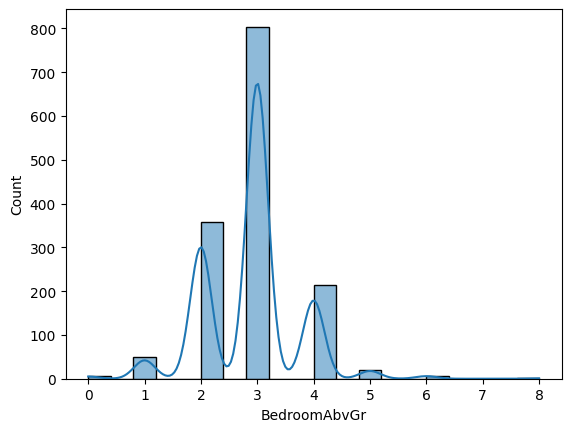

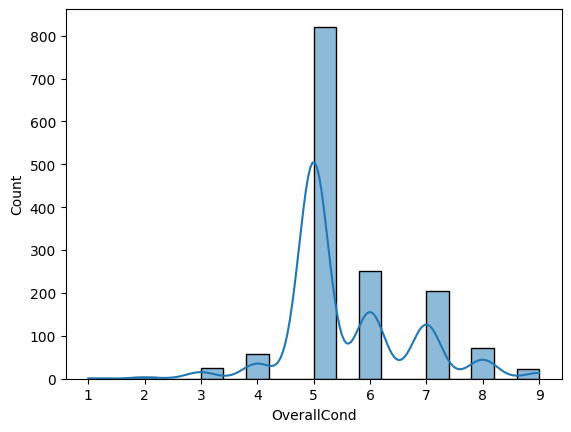

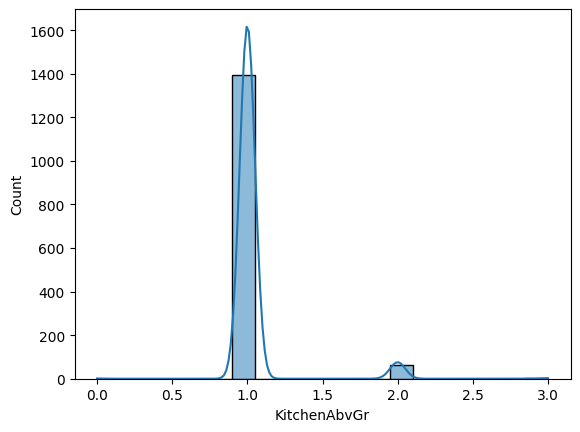

In [136]:
# 👇 Investigate `BedroomAbvGr`, `OverallCond` & `KitchenAbvGr`
sns.histplot(data["BedroomAbvGr"], bins=20, kde=True)
plt.show()

sns.histplot(data["OverallCond"], bins=20, kde=True)
plt.show()

sns.histplot(data["KitchenAbvGr"], bins=20, kde=True)
plt.show()

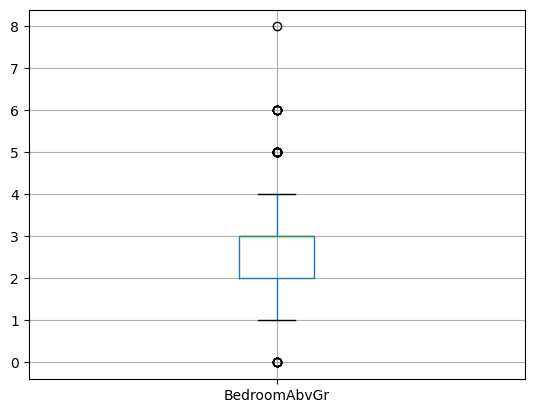

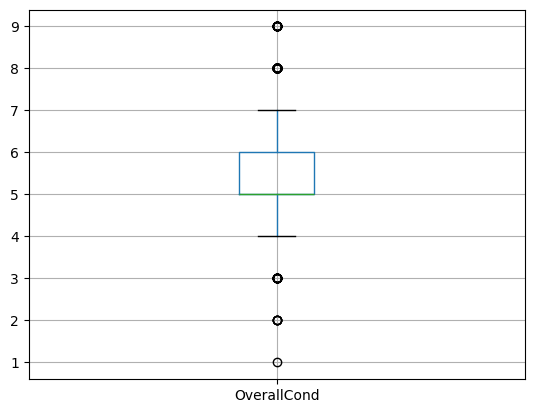

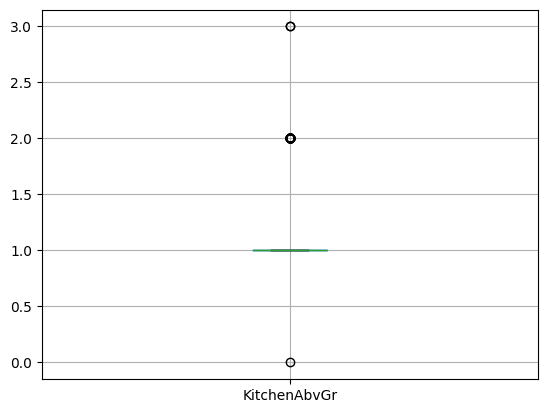

In [137]:
data[['BedroomAbvGr']].boxplot()
plt.show()

data[['OverallCond']].boxplot()
plt.show()

data[['KitchenAbvGr']].boxplot()
plt.show()

In [138]:
data.describe()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,MoSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.078410,2.866438,1.046575,5.575342,0.508090,6.321918,180921.195890
std,0.813952,0.815778,0.220338,1.112799,0.291582,2.703626,79442.502883
min,-2.263422,0.000000,0.000000,1.000000,0.000000,1.000000,34900.000000
25%,-0.516802,2.000000,1.000000,5.000000,0.246143,5.000000,129975.000000
50%,0.000000,3.000000,1.000000,5.000000,0.513776,6.000000,163000.000000
75%,0.483198,3.000000,1.000000,6.000000,0.761406,8.000000,214000.000000
max,6.455002,8.000000,3.000000,9.000000,1.000000,12.000000,755000.000000


In [139]:
# Não são muitos outliers e a distribuição não é normal -> minmaxScaler
minmaxscaler_02 = MinMaxScaler()
data['BedroomAbvGr'], data['OverallCond'], data['KitchenAbvGr'] =  minmaxscaler_02.fit_transform(data[['BedroomAbvGr','OverallCond','KitchenAbvGr']]).T

data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,GarageFinish,CentralAir,MoSold,SalePrice
0,0.380070,0.375,0.333333,0.500,0.316729,RFn,Y,2,208500
1,-0.312090,0.375,0.333333,0.875,0.069650,RFn,Y,5,181500
2,0.497489,0.375,0.333333,0.500,0.228124,RFn,Y,9,223500
3,0.390885,0.375,0.333333,0.500,0.442583,Unf,Y,2,140000
4,1.134029,0.500,0.333333,0.500,0.566894,RFn,Y,12,250000


## (4) Feature Encoding

In [140]:
# Investigate `GarageFinish`
data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,GarageFinish,CentralAir,MoSold,SalePrice
0,0.380070,0.375,0.333333,0.500,0.316729,RFn,Y,2,208500
1,-0.312090,0.375,0.333333,0.875,0.069650,RFn,Y,5,181500
2,0.497489,0.375,0.333333,0.500,0.228124,RFn,Y,9,223500
3,0.390885,0.375,0.333333,0.500,0.442583,Unf,Y,2,140000
4,1.134029,0.500,0.333333,0.500,0.566894,RFn,Y,12,250000


In [141]:
data['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin', 'NoGarage'], dtype=object)

In [ ]:
# Errado!! Existe uma ordem entre Unf -> RFn -> Fin ==> Ordinal encoding
# ordinal_encoder = OrdinalEncoder(categories=[["NoGarage", "Unf", "RFn", "Fin"]])
# data['GarageFinish'] = ordinal_encoder.fit_transform(data[['GarageFinish']])
# data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,GarageFinish,CentralAir,MoSold,SalePrice
0,0.380070,0.375,0.333333,0.500,0.316729,2.0,Y,2,208500
1,-0.312090,0.375,0.333333,0.875,0.069650,2.0,Y,5,181500
2,0.497489,0.375,0.333333,0.500,0.228124,2.0,Y,9,223500
3,0.390885,0.375,0.333333,0.500,0.442583,1.0,Y,2,140000
4,1.134029,0.500,0.333333,0.500,0.566894,2.0,Y,12,250000


In [142]:
# Certo: Unfinished or no garage are definitely worse that rough finished -> OneHotEncoding
GF_ohe = OneHotEncoder(sparse_output=False)
GF_ohe.fit(data[['GarageFinish']])

data[GF_ohe.get_feature_names_out()] = GF_ohe.transform(data[['GarageFinish']])

data.drop(columns=['GarageFinish'], inplace=True) # Drop original column

data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,CentralAir,MoSold,SalePrice,GarageFinish_Fin,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf
0,0.380070,0.375,0.333333,0.500,0.316729,Y,2,208500,0.0,0.0,1.0,0.0
1,-0.312090,0.375,0.333333,0.875,0.069650,Y,5,181500,0.0,0.0,1.0,0.0
2,0.497489,0.375,0.333333,0.500,0.228124,Y,9,223500,0.0,0.0,1.0,0.0
3,0.390885,0.375,0.333333,0.500,0.442583,Y,2,140000,0.0,0.0,0.0,1.0
4,1.134029,0.500,0.333333,0.500,0.566894,Y,12,250000,0.0,0.0,1.0,0.0


In [143]:
# Investigate `CentralAir`
data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,CentralAir,MoSold,SalePrice,GarageFinish_Fin,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf
0,0.380070,0.375,0.333333,0.500,0.316729,Y,2,208500,0.0,0.0,1.0,0.0
1,-0.312090,0.375,0.333333,0.875,0.069650,Y,5,181500,0.0,0.0,1.0,0.0
2,0.497489,0.375,0.333333,0.500,0.228124,Y,9,223500,0.0,0.0,1.0,0.0
3,0.390885,0.375,0.333333,0.500,0.442583,Y,2,140000,0.0,0.0,0.0,1.0
4,1.134029,0.500,0.333333,0.500,0.566894,Y,12,250000,0.0,0.0,1.0,0.0


In [144]:
data['CentralAir'].unique()

array(['Y', 'N'], dtype=object)

In [145]:
# É uma feature binária -> OneHotEncoder binário
CA_ohe = OneHotEncoder(sparse_output=False, drop='if_binary', categories=[['N', 'Y']])
data['CentralAir'] = CA_ohe.fit_transform(data[['CentralAir']])
data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,CentralAir,MoSold,SalePrice,GarageFinish_Fin,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf
0,0.380070,0.375,0.333333,0.500,0.316729,1.0,2,208500,0.0,0.0,1.0,0.0
1,-0.312090,0.375,0.333333,0.875,0.069650,1.0,5,181500,0.0,0.0,1.0,0.0
2,0.497489,0.375,0.333333,0.500,0.228124,1.0,9,223500,0.0,0.0,1.0,0.0
3,0.390885,0.375,0.333333,0.500,0.442583,1.0,2,140000,0.0,0.0,0.0,1.0
4,1.134029,0.500,0.333333,0.500,0.566894,1.0,12,250000,0.0,0.0,1.0,0.0


## (5) Feature Engineering

In [ ]:
# MoSold - a feature can also be temporal -> cíclico -> seno e cosseno:
# https://ianlondon.github.io/posts/encoding-cyclical-features-24-hour-time/
data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,CentralAir,MoSold,SalePrice,GarageFinish_Fin,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf
0,0.380070,0.375,0.333333,0.500,0.316729,1.0,2,208500,0.0,0.0,1.0,0.0
1,-0.312090,0.375,0.333333,0.875,0.069650,1.0,5,181500,0.0,0.0,1.0,0.0
2,0.497489,0.375,0.333333,0.500,0.228124,1.0,9,223500,0.0,0.0,1.0,0.0
3,0.390885,0.375,0.333333,0.500,0.442583,1.0,2,140000,0.0,0.0,0.0,1.0
4,1.134029,0.500,0.333333,0.500,0.566894,1.0,12,250000,0.0,0.0,1.0,0.0


In [148]:
data["MoSold"].value_counts()

MoSold
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: count, dtype: int64

In [ ]:
months_per_year = 12
data['sin_MoSold'] = np.sin(2*np.pi*(data.MoSold)/months_per_year)
data['cos_MoSold'] = np.cos(2*np.pi*(data.MoSold)/months_per_year)
data.drop(columns=['MoSold'], inplace=True)

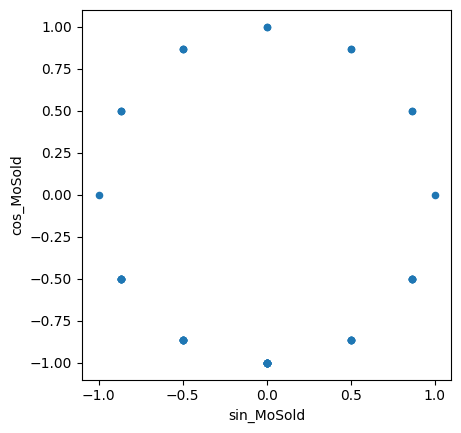

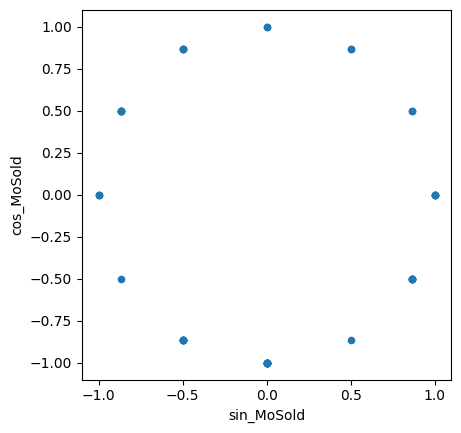

In [153]:
data.sample(50).plot.scatter('sin_MoSold', 'cos_MoSold').set_aspect('equal')
plt.show()

In [154]:
data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,CentralAir,SalePrice,GarageFinish_Fin,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,sin_MoSold,cos_MoSold
0,0.380070,0.375,0.333333,0.500,0.316729,1.0,208500,0.0,0.0,1.0,0.0,8.660254e-01,5.000000e-01
1,-0.312090,0.375,0.333333,0.875,0.069650,1.0,181500,0.0,0.0,1.0,0.0,5.000000e-01,-8.660254e-01
2,0.497489,0.375,0.333333,0.500,0.228124,1.0,223500,0.0,0.0,1.0,0.0,-1.000000e+00,-1.836970e-16
3,0.390885,0.375,0.333333,0.500,0.442583,1.0,140000,0.0,0.0,0.0,1.0,8.660254e-01,5.000000e-01
4,1.134029,0.500,0.333333,0.500,0.566894,1.0,250000,0.0,0.0,1.0,0.0,-2.449294e-16,1.000000e+00


## (6) Export the preprocessed dataset

In [156]:
data.to_csv("../data/preparation/clean_dataset.csv", index=False)